In [11]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Clock-D19-EPM/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
c19_epm_file = "/work/mk423/CLOCK_Apr_2024/C19_EPM_Apr_2024_Data.pkl"
proj_file = PROJECT_PATH + "c19_epm_apr_2024_projection.csv"
bxcx_proj_file = PROJECT_PATH + "bxcx_c19_epm_apr_2024_projection.csv"

mean_file = PROJECT_PATH + "c19_epm_apr_2024_mean_scores.csv"
bxcx_mean_file = PROJECT_PATH + "bxcx_c19_epm_apr_2024_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


FEATURE_LIST = ['X_psd','X_coh','X_gc']
FEATURE_WEIGHT = [10,1,1]

def get_3_net_aucs(s,y,y_group=None):
    
    auc_mean_list = []
    auc_stderr_list =[]
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        mean = np.mean([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"])
        stderr = np.std([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"]) / np.sqrt(len(auc_dict.keys()))
        
        auc_mean_list.append(mean)
        auc_stderr_list.append(stderr)
        
    return auc_mean_list, auc_stderr_list

def get_3_net_auc_dict(s,y,y_group=None):
    auc_dict_list = []
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        auc_dict_list.append(auc_dict)
        
    return auc_dict_list


In [8]:
dataDict = pickle.load(open(c19_epm_file,"rb"))

X = np.hstack([weight*dataDict[feature] for weight,feature in zip(FEATURE_WEIGHT,FEATURE_LIST)])
y_time = dataDict['y_time']
y_mouse = np.array(dataDict['y_mouse'])
y_condition = np.array(["CLOCK"]*y_mouse.shape[0])
y_task = 1-dataDict['y_hc']
y_roi = dataDict["y_roi"]
y_expDate = dataDict['y_expDate']
#y_sex = np.array(dataDict['y_sex'])
s = model.project(X)

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


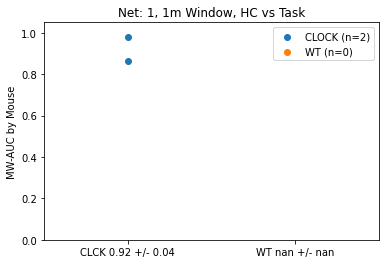

CLOCK Data Points [0.9777777777777777, 0.8611111111111112]
WT Data Points []


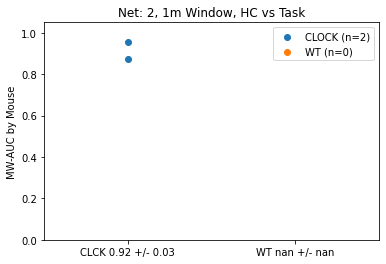

CLOCK Data Points [0.9555555555555556, 0.875]
WT Data Points []


In [12]:
for net in range(2):
    auc_list = []
    auc_list_WT = []
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse

        s_mouse = s[mouse_mask==1,net]
        y_task_mouse = y_task[mouse_mask==1]
        y_cond_mouse = y_condition[mouse_mask==1][0]
        
        
        temp_s = s_mouse[:-int(s_mouse.shape[0]%60)].reshape(-1,60)
        temp_y = y_task_mouse[:-int(y_task_mouse.shape[0]%60)].reshape(-1,60)

        temp_s = np.mean(temp_s,axis=1)
        temp_y = np.mean(temp_y,axis=1) > 0.5
        auc, pval = model.mw_auc(temp_s,temp_y)

        if y_cond_mouse=="CLOCK":
            auc_list.append(auc)
        else:
            auc_list_WT.append(auc)

    plt.scatter(np.ones(len(auc_list)),auc_list,label="CLOCK (n={})".format(len(auc_list)))
    plt.scatter(np.ones(len(auc_list_WT))*2,auc_list_WT,label="WT (n={})".format(len(auc_list_WT)))
    
    plt.title("Net: {}, 1m Window, HC vs Task".format(net+1))
    plt.ylim([0,1.05])
    plt.xlim([0.5,2.5])
    plt.xticks([1,2],["CLCK {:.2f} +/- {:.2f}".format(np.mean(auc_list),np.std(auc_list)/np.sqrt(len(auc_list))),"WT {:.2f} +/- {:.2f}".format(np.mean(auc_list_WT),np.std(auc_list_WT)/np.sqrt(len(auc_list_WT)))])
    plt.ylabel("MW-AUC by Mouse")
    plt.legend()
    plt.show()
            
    print("CLOCK Data Points",auc_list)
    print("WT Data Points",auc_list_WT)
        

In [15]:
from scipy.stats import boxcox

all_hc_v_task_aucs = model.score(X,y_task,y_mouse,return_dict=True)
all_hc_v_task_aucs_3_net = get_3_net_auc_dict(s,y_task,y_mouse)
coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())
agg_score = s[:,:3] @ coeffs

results_dict = {
    "agg score":agg_score,
    "net 1 scores":boxcox(20*s[:,0])[0],
    "net 2 scores":boxcox(20*s[:,1])[0],
    "net 3 scores":boxcox(20*s[:,2])[0],
    "mouse":y_mouse,
    #"sex":y_sex,
    "roi":y_roi,
    "condition":y_condition,
    "in-task":y_task,
    "time":y_time,
    "expDate":y_expDate,
    "hc_v_task auc":[all_hc_v_task_aucs[mouse][0] for mouse in y_mouse],
    "net 1 hc_v_task auc":[all_hc_v_task_aucs_3_net[0][mouse][0] for mouse in y_mouse],
    "net 2 hc_v_task auc":[all_hc_v_task_aucs_3_net[1][mouse][0] for mouse in y_mouse],
    "net 3 hc_v_task auc":[all_hc_v_task_aucs_3_net[2][mouse][0] for mouse in y_mouse],
}

df = pd.DataFrame.from_dict(results_dict)
df.to_csv(bxcx_proj_file)
df.head()

,agg score,net 1 scores,net 2 scores,net 3 scores,mouse,roi,condition,in-task,time,expDate,hc_v_task auc,net 1 hc_v_task auc,net 2 hc_v_task auc,net 3 hc_v_task auc
0,2.788229,1.149400,0.696010,-0.654113,Mouse67151,NaN,CLOCK,0.0,1,041624,0.670959,0.63922,0.670891,0.555512
1,2.632651,1.056085,0.636833,-1.289742,Mouse67151,NaN,CLOCK,0.0,3,041624,0.670959,0.63922,0.670891,0.555512
2,1.589763,0.528175,-0.102226,0.490724,Mouse67151,NaN,CLOCK,0.0,4,041624,0.670959,0.63922,0.670891,0.555512
3,3.818605,1.318809,1.279212,0.334941,Mouse67151,NaN,CLOCK,0.0,5,041624,0.670959,0.63922,0.670891,0.555512
4,2.236664,0.930419,0.361647,-0.779549,Mouse67151,NaN,CLOCK,0.0,6,041624,0.670959,0.63922,0.670891,0.555512


In [17]:
all_hc_v_task_aucs = model.score(X,y_task,y_mouse,return_dict=True)
all_hc_v_task_aucs_3_net = get_3_net_auc_dict(s,y_task,y_mouse)
coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())
agg_score = s[:,:3] @ coeffs

results_dict = {
    "agg score":agg_score,
    "net 1 scores":s[:,0],
    "net 2 scores":s[:,1],
    "net 3 scores":s[:,2],
    "mouse":y_mouse,
    #"sex":y_sex,
    "roi":y_roi,
    "condition":y_condition,
    "in-task":y_task,
    "time":y_time,
    "expDate":y_expDate,
    "hc_v_task auc":[all_hc_v_task_aucs[mouse][0] for mouse in y_mouse],
    "net 1 hc_v_task auc":[all_hc_v_task_aucs_3_net[0][mouse][0] for mouse in y_mouse],
    "net 2 hc_v_task auc":[all_hc_v_task_aucs_3_net[1][mouse][0] for mouse in y_mouse],
    "net 3 hc_v_task auc":[all_hc_v_task_aucs_3_net[2][mouse][0] for mouse in y_mouse],
}

df = pd.DataFrame.from_dict(results_dict)
df.to_csv(proj_file)
df.head()

,agg score,net 1 scores,net 2 scores,net 3 scores,mouse,roi,condition,in-task,time,expDate,hc_v_task auc,net 1 hc_v_task auc,net 2 hc_v_task auc,net 3 hc_v_task auc
0,2.788229,0.123667,0.093573,0.023166,Mouse67151,NaN,CLOCK,0.0,1,041624,0.670959,0.63922,0.670891,0.555512
1,2.632651,0.116482,0.089140,0.007553,Mouse67151,NaN,CLOCK,0.0,3,041624,0.670959,0.63922,0.670891,0.555512
2,1.589763,0.079837,0.045062,0.078016,Mouse67151,NaN,CLOCK,0.0,4,041624,0.670959,0.63922,0.670891,0.555512
3,3.818605,0.137250,0.145430,0.068358,Mouse67151,NaN,CLOCK,0.0,5,041624,0.670959,0.63922,0.670891,0.555512
4,2.236664,0.107143,0.070367,0.019308,Mouse67151,NaN,CLOCK,0.0,6,041624,0.670959,0.63922,0.670891,0.555512


In [18]:
#Get per mouse average scores, average scores in HC and average scores in EPM
mouse_list = []
avg_score_list = []
avg_hc_score_list = []
avg_task_score_list = []
condition_list = []
#sex_list = []


#if boxcox
bxcx=True
bxcx_s = []
if bxcx:
    for i in range(s.shape[1]):
        bxcx_s.append(boxcox(20*s[:,i])[0].reshape(-1,1))
    
    bxcx_s = np.hstack(bxcx_s)

    
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
        task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
        avg_score = np.mean(bxcx_s[mouse_mask==1,:3],axis=0)
        avg_score_hc = np.mean(bxcx_s[hc_mouse_mask==1,:3],axis=0)
        avg_score_task = np.mean(bxcx_s[task_mouse_mask==1,:3],axis=0)

        mouse_list.append(mouse)
        avg_score_list.append(avg_score)
        avg_hc_score_list.append(avg_score_hc)
        avg_task_score_list.append(avg_score_task)
        condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
        #sex_list.append(np.unique(y_sex[y_mouse==mouse])[0])
else:
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
        task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
        avg_score = np.mean(s[mouse_mask==1,:3],axis=0)
        avg_score_hc = np.mean(s[hc_mouse_mask==1,:3],axis=0)
        avg_score_task = np.mean(s[task_mouse_mask==1,:3],axis=0)

        mouse_list.append(mouse)
        avg_score_list.append(avg_score)
        avg_hc_score_list.append(avg_score_hc)
        avg_task_score_list.append(avg_score_task)
        condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
        #sex_list.append(np.unique(y_sex[y_mouse==mouse])[0])
    
avg_score_list = np.array(avg_score_list)
avg_hc_score_list = np.array(avg_hc_score_list)
avg_task_score_list = np.array(avg_task_score_list)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())

mag_score_list = avg_score_list*coeffs
mag_hc_score_list = avg_hc_score_list*coeffs
mag_task_score_list = avg_task_score_list*coeffs

net_impact_scores = mag_score_list / np.sum(mag_score_list,axis=1).reshape(-1,1)
net_hc_scores = mag_hc_score_list / np.sum(mag_hc_score_list,axis=1).reshape(-1,1)
net_task_scores = mag_task_score_list / np.sum(mag_task_score_list,axis=1).reshape(-1,1)

proj_dict = {
    "mouse":mouse_list,
    "condition":condition_list,
    #"sex":sex_list,
    "composite avgScore":np.sum(mag_score_list,axis=1),
    "composite avgHCScore":np.sum(mag_hc_score_list,axis=1),
    "composite avgTaskScore":np.sum(mag_task_score_list,axis=1),
    
    "net 1 avgScore":avg_score_list[:,0],
    "net 1 avgHCScore":avg_hc_score_list[:,0],
    "net 1 avgTaskScore":avg_task_score_list[:,0],
    "net 2 avgScore":avg_score_list[:,1],
    "net 2 avgHCScore":avg_hc_score_list[:,1],
    "net 2 avgTaskScore":avg_task_score_list[:,1],
    "net 3 avgScore":avg_score_list[:,2],
    "net 3 avgHCScore":avg_hc_score_list[:,2],
    "net 3 avgTaskScore":avg_task_score_list[:,2],
    
    #"net 1 avgImpact":net_impact_scores[:,0],
    #"net 1 avgHCImpact":net_hc_scores[:,0],
    #"net 1 avgTaskImpact":net_task_scores[:,0],
    #"net 2 avgImpact":net_impact_scores[:,1],
    #"net 2 avgHCImpact":net_hc_scores[:,1],
    #"net 2 avgTaskImpact":net_task_scores[:,1],
    #"net 3 avgImpact":net_impact_scores[:,2],
    #"net 3 avgHCImpact":net_hc_scores[:,2],
    #"net 3 avgTaskImpact":net_task_scores[:,2],
}
df_means = pd.DataFrame.from_dict(proj_dict)
df_means.to_csv(bxcx_mean_file)
df_means.head()

,mouse,condition,composite avgScore,composite avgHCScore,composite avgTaskScore,net 1 avgScore,net 1 avgHCScore,net 1 avgTaskScore,net 2 avgScore,net 2 avgHCScore,net 2 avgTaskScore,net 3 avgScore,net 3 avgHCScore,net 3 avgTaskScore
0,Mouse67151,CLOCK,31.411346,26.998466,33.685574,1.224699,1.106006,1.285868,1.177564,0.986227,1.276173,-0.301900,-0.384890,-0.259130
1,Mouse67152,CLOCK,24.036438,20.798820,25.429945,0.923412,0.808481,0.972879,0.922987,0.802241,0.974956,-0.549556,-0.685924,-0.490862


In [23]:
#Get per mouse average scores, average scores in HC and average scores in EPM
mouse_list = []
avg_score_list = []
avg_hc_score_list = []
avg_task_score_list = []
condition_list = []
sex_list = []


#if boxcox
bxcx=False
bxcx_s = []
if bxcx:
    for i in range(s.shape[1]):
        bxcx_s.append(boxcox(20*s[:,i])[0].reshape(-1,1))
    
    bxcx_s = np.hstack(bxcx_s)

    
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
        task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
        avg_score = np.mean(bxcx_s[mouse_mask==1,:3],axis=0)
        avg_score_hc = np.mean(bxcx_s[hc_mouse_mask==1,:3],axis=0)
        avg_score_task = np.mean(bxcx_s[task_mouse_mask==1,:3],axis=0)

        mouse_list.append(mouse)
        avg_score_list.append(avg_score)
        avg_hc_score_list.append(avg_score_hc)
        avg_task_score_list.append(avg_score_task)
        condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
        #sex_list.append(np.unique(y_sex[y_mouse==mouse])[0])
else:
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
        task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
        avg_score = np.mean(s[mouse_mask==1,:3],axis=0)
        avg_score_hc = np.mean(s[hc_mouse_mask==1,:3],axis=0)
        avg_score_task = np.mean(s[task_mouse_mask==1,:3],axis=0)

        mouse_list.append(mouse)
        avg_score_list.append(avg_score)
        avg_hc_score_list.append(avg_score_hc)
        avg_task_score_list.append(avg_score_task)
        condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
        #sex_list.append(np.unique(y_sex[y_mouse==mouse])[0])
    
avg_score_list = np.array(avg_score_list)
avg_hc_score_list = np.array(avg_hc_score_list)
avg_task_score_list = np.array(avg_task_score_list)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())

mag_score_list = avg_score_list*coeffs
mag_hc_score_list = avg_hc_score_list*coeffs
mag_task_score_list = avg_task_score_list*coeffs

net_impact_scores = mag_score_list / np.sum(mag_score_list,axis=1).reshape(-1,1)
net_hc_scores = mag_hc_score_list / np.sum(mag_hc_score_list,axis=1).reshape(-1,1)
net_task_scores = mag_task_score_list / np.sum(mag_task_score_list,axis=1).reshape(-1,1)

proj_dict = {
    "mouse":mouse_list,
    "condition":condition_list,
    #"sex":sex_list,
    "composite avgScore":np.sum(mag_score_list,axis=1),
    "composite avgHCScore":np.sum(mag_hc_score_list,axis=1),
    "composite avgTaskScore":np.sum(mag_task_score_list,axis=1),
    
    "net 1 avgScore":avg_score_list[:,0],
    "net 1 avgHCScore":avg_hc_score_list[:,0],
    "net 1 avgTaskScore":avg_task_score_list[:,0],
    "net 2 avgScore":avg_score_list[:,1],
    "net 2 avgHCScore":avg_hc_score_list[:,1],
    "net 2 avgTaskScore":avg_task_score_list[:,1],
    "net 3 avgScore":avg_score_list[:,2],
    "net 3 avgHCScore":avg_hc_score_list[:,2],
    "net 3 avgTaskScore":avg_task_score_list[:,2],
    
    #"net 1 avgImpact":net_impact_scores[:,0],
    #"net 1 avgHCImpact":net_hc_scores[:,0],
    #"net 1 avgTaskImpact":net_task_scores[:,0],
    #"net 2 avgImpact":net_impact_scores[:,1],
    #"net 2 avgHCImpact":net_hc_scores[:,1],
    #"net 2 avgTaskImpact":net_task_scores[:,1],
    #"net 3 avgImpact":net_impact_scores[:,2],
    #"net 3 avgHCImpact":net_hc_scores[:,2],
    #"net 3 avgTaskImpact":net_task_scores[:,2],
}
df_means = pd.DataFrame.from_dict(proj_dict)
df_means.to_csv(mean_file)
df_means.head()

,mouse,condition,composite avgScore,composite avgHCScore,composite avgTaskScore,net 1 avgScore,net 1 avgHCScore,net 1 avgTaskScore,net 2 avgScore,net 2 avgHCScore,net 2 avgTaskScore,net 3 avgScore,net 3 avgHCScore,net 3 avgTaskScore
0,Mouse67151,CLOCK,3.676500,3.273726,3.884072,0.131282,0.121816,0.13616,0.141561,0.123114,0.151068,0.041890,0.038460,0.043658
1,Mouse67152,CLOCK,3.030106,2.772208,3.141111,0.108291,0.100045,0.11184,0.116709,0.106307,0.121187,0.032438,0.027343,0.034631
